In [ ]:
# Advanced Time Series Forecasting with Prophet and Neural Network Hybridization

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Prophet / fbprophet import
try:
    from prophet import Prophet
except ImportError:
    from fbprophet import Prophet  # fallback

# Make plots appear inside the notebook
%matplotlib inline

# --------------------
# Configuration values
# --------------------
RANDOM_SEED = 42

# synthetic data
N_DAYS = 3 * 365  # ~3 years

# rolling origin cross-validation
N_SPLITS = 3      # you can increase to 5 later
FORECAST_HORIZON = 30  # days

# LSTM settings
LOOKBACK = 30
LSTM_UNITS = 64
DENSE_UNITS = 32
BATCH_SIZE = 32
EPOCHS = 10          # set to 20 later if you want better training
LEARNING_RATE = 1e-3
VALIDATION_SPLIT = 0.1

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


In [4]:
def generate_synthetic_time_series(n_days: int = N_DAYS, seed: int = RANDOM_SEED) -> pd.DataFrame:
    """
    Generate synthetic daily time series data with:
    - trend
    - yearly, weekly, and daily seasonality
    - 2 external regressors: promo_flag, price_index
    - holiday effect
    """
    rng = np.random.default_rng(seed)
    dates = pd.date_range(start="2018-01-01", periods=n_days, freq="D")
    t = np.arange(n_days)

    # Trend: slowly increasing
    trend = 0.02 * t

    # Yearly seasonality (using sine)
    yearly = 10 * np.sin(2 * np.pi * t / 365.25)

    # Weekly seasonality (higher on weekends)
    day_of_week = pd.Series(dates).dt.dayofweek.values  # 0=Mon,...,6=Sun
    weekly = np.where(day_of_week < 5, 0.0, 5.0)  # weekend boost

    # Daily seasonality (small oscillation)
    daily = 2 * np.sin(2 * np.pi * t)

    # External regressor 1: promo_flag (random campaigns)
    promo_flag = (rng.random(n_days) < 0.1).astype(int)

    # External regressor 2: price_index (slow random walk)
    price_noise = rng.normal(0, 0.02, size=n_days)
    price_index = 1.0 + np.cumsum(price_noise)

    # Holiday effect: some fake December holidays
    is_holiday = ((pd.Series(dates).dt.month == 12) &
                  (pd.Series(dates).dt.day.isin([24, 25, 31]))).astype(int)
    holiday_effect = 8 * is_holiday

    # Base level + all components + noise
    base = 50
    noise = rng.normal(0, 3, size=n_days)

    y = (
        base
        + trend
        + yearly
        + weekly
        + daily
        + 5 * promo_flag
        - 10 * (price_index - price_index.mean())
        + holiday_effect
        + noise
    )

    df = pd.DataFrame({
        "ds": dates,
        "y": y,
        "promo_flag": promo_flag,
        "price_index": price_index,
        "is_holiday": is_holiday,
        "day_of_week": day_of_week,
    })

    return df


# Generate and preview the data
df = generate_synthetic_time_series()
df.head()


,ds,y,promo_flag,price_index,is_holiday,day_of_week
0,2018-01-01,45.943346,0,0.996926,0,0
1,2018-01-02,45.039271,0,1.026007,0,1
2,2018-01-03,41.896571,0,1.016878,0,2
3,2018-01-04,46.322803,0,1.039523,0,3
4,2018-01-05,47.379350,1,1.026635,0,4


In [5]:
EXOGENOUS_COLS = ["promo_flag", "price_index", "is_holiday"]

def prepare_prophet_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """Prepare dataframe for Prophet (ds, y, plus regressors)."""
    cols = ["ds", "y"] + EXOGENOUS_COLS
    return df[cols].copy()

def fit_prophet_model(df_train: pd.DataFrame) -> Prophet:
    """
    Fit a Prophet model with yearly/weekly seasonality and external regressors.
    """
    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        interval_width=0.95,
    )
    for reg in EXOGENOUS_COLS:
        m.add_regressor(reg)

    m.fit(df_train)
    return m

def forecast_with_prophet(model: Prophet, df_future: pd.DataFrame) -> pd.DataFrame:
    """
    Forecast using Prophet for given future dataframe.
    The future dataframe must contain ds + regressors.
    """
    forecast = model.predict(df_future)
    return forecast


In [6]:
LSTM_FEATURE_COLS = ["y", "promo_flag", "price_index", "is_holiday", "day_of_week"]

def create_supervised_sequences(
    df_scaled: pd.DataFrame, feature_cols, target_col="y", lookback=LOOKBACK
):
    """
    Turn a dataframe into supervised sequences for LSTM:
    - X: [samples, lookback, num_features]
    - y: [samples]
    """
    features = df_scaled[feature_cols].values
    target = df_scaled[target_col].values

    X, y = [], []
    for i in range(len(df_scaled) - lookback):
        X.append(features[i:i+lookback])
        y.append(target[i+lookback])
    return np.array(X), np.array(y)

def build_lstm_model(input_shape):
    """
    Simple LSTM regression model.
    """
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.LSTM(LSTM_UNITS, return_sequences=False))
    model.add(layers.Dense(DENSE_UNITS, activation="relu"))
    model.add(layers.Dense(1))

    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss="mse")
    return model

def fit_lstm(df_train: pd.DataFrame):
    """
    Fit LSTM on the training data.
    Returns model, scaler.
    """
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df_train[LSTM_FEATURE_COLS])
    df_scaled = pd.DataFrame(scaled, columns=LSTM_FEATURE_COLS, index=df_train.index)

    X_train, y_train = create_supervised_sequences(
        df_scaled, feature_cols=LSTM_FEATURE_COLS, target_col="y", lookback=LOOKBACK
    )

    input_shape = (LOOKBACK, len(LSTM_FEATURE_COLS))
    model = build_lstm_model(input_shape)

    history = model.fit(
        X_train,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=VALIDATION_SPLIT,
        verbose=1,
    )

    return model, scaler, history

def forecast_lstm_multi_step(
    model,
    df_history: pd.DataFrame,
    scaler: MinMaxScaler,
    horizon: int,
    lookback: int = LOOKBACK,
):
    """
    Multi-step forecast: predict 'horizon' steps ahead recursively.
    """
    scaled_all = scaler.transform(df_history[LSTM_FEATURE_COLS])
    df_scaled = pd.DataFrame(scaled_all, columns=LSTM_FEATURE_COLS, index=df_history.index)

    preds_scaled = []
    window = df_scaled.iloc[-lookback:].copy()

    for _ in range(horizon):
        X_input = window[LSTM_FEATURE_COLS].values.reshape(1, lookback, len(LSTM_FEATURE_COLS))
        y_scaled_pred = model.predict(X_input, verbose=0)[0, 0]

        # new row: copy last row, update y with prediction
        new_row = window.iloc[-1].copy()
        new_row["y"] = y_scaled_pred

        window = pd.concat([window, new_row.to_frame().T])
        window = window.iloc[-lookback:]

        preds_scaled.append(y_scaled_pred)

    # To invert scaling of y only, we build dummy array with all features 0 and last col y
    preds_scaled_arr = np.array(preds_scaled).reshape(-1, 1)
    zeros_features = np.zeros((len(preds_scaled_arr), len(LSTM_FEATURE_COLS)-1))
    concat = np.concatenate([zeros_features, preds_scaled_arr], axis=1)
    inv = scaler.inverse_transform(concat)
    y_inv = inv[:, -1]
    return y_inv


In [7]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def rolling_origin_backtest_prophet(
    df: pd.DataFrame,
    n_splits: int = N_SPLITS,
    horizon: int = FORECAST_HORIZON,
):
    """
    Rolling origin backtesting for Prophet.
    """
    df_prophet = prepare_prophet_dataframe(df)

    total_points = len(df_prophet)
    initial_train_size = total_points - (n_splits * horizon)

    rmses, maes = [], []

    for split in range(n_splits):
        print(f"Prophet split {split+1}/{n_splits}")
        train_end = initial_train_size + split * horizon
        test_end = train_end + horizon

        df_train = df_prophet.iloc[:train_end].copy()
        df_test = df_prophet.iloc[train_end:test_end].copy()

        model = fit_prophet_model(df_train)

        # For backtest, we already know future ds and regressors (from df_test)
        future = df_test.copy()
        forecast = forecast_with_prophet(model, future)

        y_true = df_test["y"].values
        y_pred = forecast["yhat"].values

        rmses.append(rmse(y_true, y_pred))
        maes.append(mae(y_true, y_pred))

    return {"rmse": rmses, "mae": maes}

def rolling_origin_backtest_lstm(
    df: pd.DataFrame,
    n_splits: int = N_SPLITS,
    horizon: int = FORECAST_HORIZON,
):
    """
    Rolling origin backtesting for LSTM.
    """
    total_points = len(df)
    initial_train_size = total_points - (n_splits * horizon)

    rmses, maes = [], []

    for split in range(n_splits):
        print(f"LSTM split {split+1}/{n_splits}")
        train_end = initial_train_size + split * horizon
        test_end = train_end + horizon

        df_train = df.iloc[:train_end].copy()
        df_test = df.iloc[train_end:test_end].copy()

        model, scaler, _ = fit_lstm(df_train)

        # Forecast next horizon using history until train_end
        y_pred = forecast_lstm_multi_step(
            model,
            df_history=df_train,
            scaler=scaler,
            horizon=horizon,
        )

        y_true = df_test["y"].values

        rmses.append(rmse(y_true, y_pred))
        maes.append(mae(y_true, y_pred))

    return {"rmse": rmses, "mae": maes}


In [8]:
def summarize_metrics(name, metrics):
    rmse_vals = np.array(metrics["rmse"])
    mae_vals = np.array(metrics["mae"])
    print(f"\n=== {name} Backtesting Results ===")
    print(f"RMSE per fold: {rmse_vals}")
    print(f"RMSE mean: {rmse_vals.mean():.4f}, std: {rmse_vals.std():.4f}")
    print(f"MAE  per fold: {mae_vals}")
    print(f"MAE  mean: {mae_vals.mean():.4f}, std: {mae_vals.std():.4f}")

# 1) Prophet backtest
prophet_metrics = rolling_origin_backtest_prophet(df)
summarize_metrics("Prophet", prophet_metrics)

# 2) LSTM backtest
lstm_metrics = rolling_origin_backtest_lstm(df)
summarize_metrics("LSTM", lstm_metrics)


Prophet split 1/3


00:40:54 - cmdstanpy - INFO - Chain [1] start processing
00:40:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet split 2/3


00:40:57 - cmdstanpy - INFO - Chain [1] start processing
00:40:57 - cmdstanpy - INFO - Chain [1] done processing
00:40:57 - cmdstanpy - INFO - Chain [1] start processing


Prophet split 3/3


00:40:57 - cmdstanpy - INFO - Chain [1] done processing



=== Prophet Backtesting Results ===
RMSE per fold: [2.67165834 2.57519053 3.1032273 ]
RMSE mean: 2.7834, std: 0.2296
MAE  per fold: [2.27751109 2.12347297 2.56862822]
MAE  mean: 2.3232, std: 0.1846
LSTM split 1/3
Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0484 - val_loss: 0.0308
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0080 - val_loss: 0.0065
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0062 - val_loss: 0.0049
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0058 - val_loss: 0.0047
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - val_loss: 0.0048
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - val_loss: 0.0047
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - val_loss: 0.0047
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0055 - val_loss: 0.0047
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0055 - val_loss: 0.0047
Epoch 10/10
28/28 ━━━━━━━━━

00:41:17 - cmdstanpy - INFO - Chain [1] start processing
00:41:17 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1009 - val_loss: 0.0060
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0081 - val_loss: 0.0047
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0063 - val_loss: 0.0044
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - val_loss: 0.0042
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055 - val_loss: 0.0043
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055 - val_loss: 0.0043
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055 - val_loss: 0.0042
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0054 - val_loss: 0.0042
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0054 - val_loss: 0.0042
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - val_loss: 0.0042


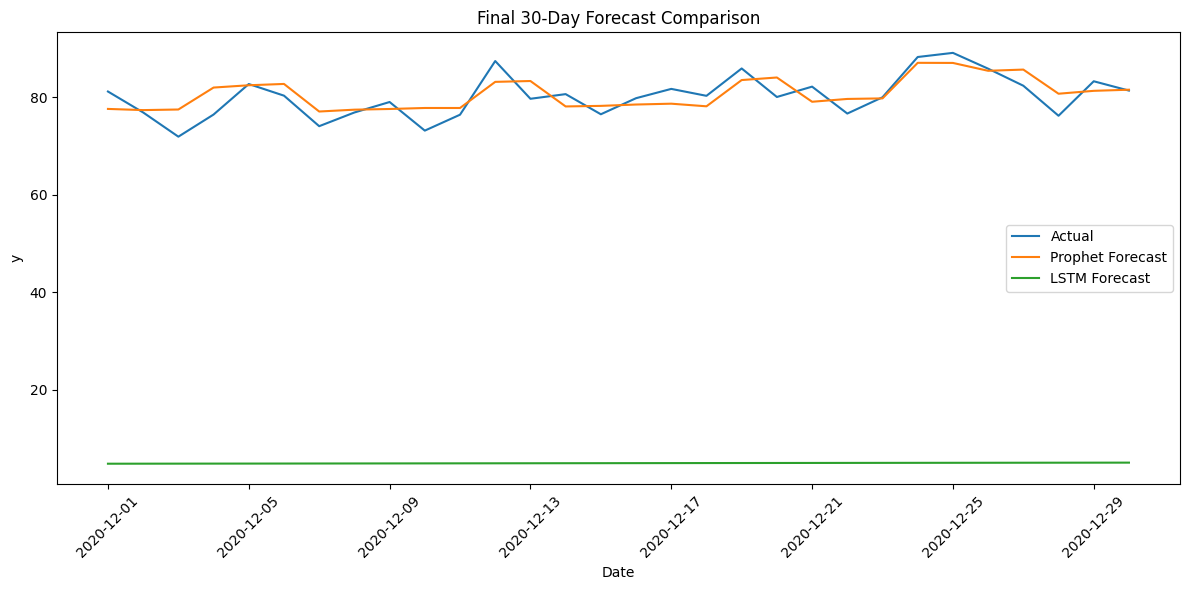

In [9]:
# Fit final Prophet on full data and forecast
df_prophet_full = prepare_prophet_dataframe(df)
prophet_full_model = fit_prophet_model(df_prophet_full)
future_full = df_prophet_full.tail(FORECAST_HORIZON).copy()  # use last horizon Ds & regressors
prophet_forecast_full = forecast_with_prophet(prophet_full_model, future_full)
prophet_y_pred_final = prophet_forecast_full["yhat"].values

# Fit final LSTM on full data and forecast
lstm_full_model, full_scaler, _ = fit_lstm(df)
lstm_y_pred_final = forecast_lstm_multi_step(
    lstm_full_model,
    df_history=df,
    scaler=full_scaler,
    horizon=FORECAST_HORIZON,
)

# Actual last horizon values
actual_last = df["y"].tail(FORECAST_HORIZON).values
dates_last = df["ds"].tail(FORECAST_HORIZON)

plt.figure(figsize=(12, 6))
plt.plot(dates_last, actual_last, label="Actual")
plt.plot(dates_last, prophet_y_pred_final, label="Prophet Forecast")
plt.plot(dates_last, lstm_y_pred_final, label="LSTM Forecast")
plt.xlabel("Date")
plt.ylabel("y")
plt.title(f"Final {FORECAST_HORIZON}-Day Forecast Comparison")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
